# Lab Assignment 4: Text Classification with Deep Learning

**Author:** Chandra Carr  
**ASU ID:** cgcarr  
**Course:** CIS 509 - Unstructured Data Analytics  
**Date Created:** February 23, 2026

In [32]:
# ============================================================
# Code Cell 1: Library Imports and Data Loading
# ============================================================

# Install required packages (uncomment if needed)
# !pip install tensorflow scikit-learn pandas numpy matplotlib pydot graphviz

# Import core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import scikit-learn utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

# ============================================================
# Load Input 1: restaurant_reviews_az.csv — first 5000 rows
# ============================================================
df = pd.read_csv('restaurant_reviews_az.csv', nrows=5000)

# Preview dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nStar rating distribution:")
print(df['stars'].value_counts().sort_index())
df.head()

Dataset shape: (5000, 10)
Columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'Sentiment']

Star rating distribution:
stars
1     783
2     369
3     403
4     775
5    2670
Name: count, dtype: int64


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,Sentiment
0,IVS7do_HBzroiCiymNdxDg,fdFgZQQYQJeEAshH4lxSfQ,sGy67CpJctjeCWClWqonjA,3,1,1,0,"OK, the hype about having Hatch chili in your ...",1/27/2020 22:59,1
1,QP2pSzSqpJTMWOCuUuyXkQ,JBLWSXBTKFvJYYiM-FnCOQ,3w7NRntdQ9h0KwDsksIt5Q,5,1,1,1,Pandemic pit stop to have an ice cream.... onl...,4/19/2020 5:33,1
2,oK0cGYStgDOusZKz9B1qug,2_9fKnXChUjC5xArfF8BLg,OMnPtRGmbY8qH_wIILfYKA,5,1,0,0,I was lucky enough to go to the soft opening a...,2/29/2020 19:43,1
3,E_ABvFCNVLbfOgRg3Pv1KQ,9MExTQ76GSKhxSWnTS901g,V9XlikTxq0My4gE8LULsjw,5,0,0,0,I've gone to claim Jumpers all over the US and...,3/14/2020 21:47,1
4,Rd222CrrnXkXukR2iWj69g,LPxuausjvDN88uPr-Q4cQA,CA5BOxKRDPGJgdUQ8OUOpw,4,1,0,0,"If you haven't been to Maynard's kitchen, it'...",1/17/2020 20:32,1


In [2]:
# ============================================================
# Code Cell 2: TF-IDF Representation (5000-dimensional)
# ============================================================

# Drop rows with missing text or star values
df_tfidf = df[['text', 'stars']].dropna().copy()

# Create binary sentiment labels: 1 = positive (4-5 stars), 0 = negative (1-2 stars)
# Reviews with 3 stars are excluded as they are neutral/ambiguous for binary classification
df_tfidf = df_tfidf[df_tfidf['stars'] != 3].copy()
df_tfidf['label'] = (df_tfidf['stars'] >= 4).astype(int)

print(f"Samples after removing neutral (3-star) reviews: {len(df_tfidf)}")
print(f"Label distribution:\n{df_tfidf['label'].value_counts()}")
print(f"  0 = Negative (1-2 stars), 1 = Positive (4-5 stars)")

# Extract text and labels
texts_tfidf = df_tfidf['text'].astype(str).tolist()
labels_tfidf = df_tfidf['label'].values

# Represent each review as a 5000-dimensional TF-IDF vector
# max_features=5000 limits the vocabulary to top 5000 terms
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(texts_tfidf).toarray()
y = labels_tfidf

print(f"\nTF-IDF matrix shape: {X_tfidf.shape}")
print(f"Each review is now represented as a {X_tfidf.shape[1]}-dimensional vector")

Samples after removing neutral (3-star) reviews: 4597
Label distribution:
label
1    3445
0    1152
Name: count, dtype: int64
  0 = Negative (1-2 stars), 1 = Positive (4-5 stars)

TF-IDF matrix shape: (4597, 5000)
Each review is now represented as a 5000-dimensional vector


In [33]:
# ============================================================
# Code Cell 3: ANN Model Design and Visualization (TF-IDF)
# ============================================================

# Define input layer — shape matches 5000-dimensional TF-IDF vectors
input_layer = Input(shape=(5000,), name='input')

# Hidden layer 1: 1000 neurons with ReLU activation
hidden1 = Dense(1000, activation='relu', name='hidden-layer-1')(input_layer)

# Hidden layer 2: 500 neurons with ReLU activation
hidden2 = Dense(500, activation='relu', name='hidden-layer-2')(hidden1)

# Output layer: 1 neuron with sigmoid activation for binary classification
# sigmoid outputs probability between 0 and 1 — appropriate for binary tasks
output_layer = Dense(1, activation='sigmoid', name='output')(hidden2)

# Assemble the model
ann_tfidf = Model(inputs=input_layer, outputs=output_layer, name='ANN_TF-IDF')

# Configure the model: binary cross-entropy loss, SGD optimizer, track accuracy
ann_tfidf.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
ann_tfidf.summary()

# Attempt to render model architecture diagram
# plot_model requires graphviz system binary — if unavailable, show text note
_png = 'ann_tfidf_model.png'
try:
    plot_model(ann_tfidf, to_file=_png,
               show_shapes=True, show_layer_names=True, dpi=100)
except Exception as e:
    pass  # graphviz not installed — expected on this system

if os.path.isfile(_png) and os.path.getsize(_png) > 0:
    img = plt.imread(_png)
    plt.figure(figsize=(4, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Note: Model diagram not available (graphviz not installed).")
    print("Architecture is shown in the summary table above.")

Model: "ANN_TF-IDF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-1 (Dense)          │ (None, 1000)           │     5,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-2 (Dense)          │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,502,001 (20.99 MB)

 Trainable params: 5,502,001 (20.99 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Note: Model diagram not available (graphviz not installed).
Architecture is shown in the summary table above.


Training samples: 3447
Testing samples:  1150
Epoch 1/10
423/431 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7414 - loss: 0.6273
Epoch 1: val_accuracy improved from None to 0.76000, saving model to best_ann_tfidf.keras

Epoch 1: finished saving model to best_ann_tfidf.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7450 - loss: 0.5946 - val_accuracy: 0.7600 - val_loss: 0.5518
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7436 - loss: 0.5657
Epoch 2: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7459 - loss: 0.5621 - val_accuracy: 0.7600 - val_loss: 0.5453
Epoch 3/10
428/431 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7434 - loss: 0.5611
Epoch 3: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7459 - loss: 0.5569 - val_accuracy: 0.7600 - val_loss: 0.5406
Epoch 4/10
423/431 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7690 - loss: 0.5266
Epoch 4: va

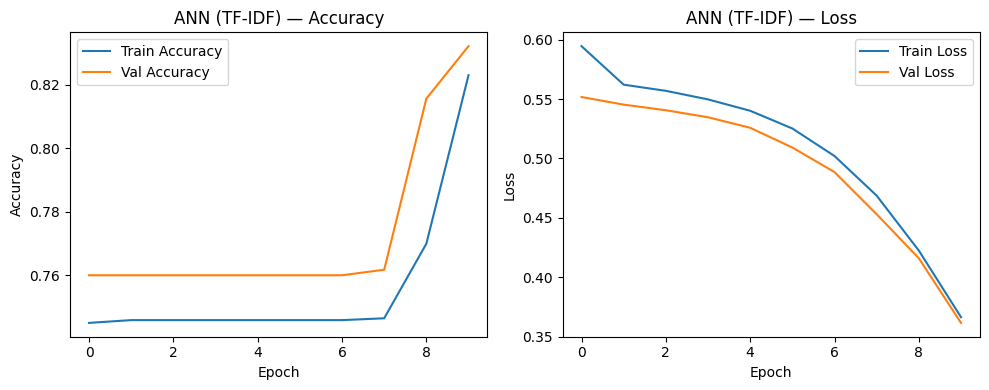


Final Test Accuracy (ANN / TF-IDF): 0.8322


In [4]:
# ============================================================
# Code Cell 4: Fit ANN Model (TF-IDF) with 75/25 Train/Test Split
# ============================================================

# Split data: 75% training, 25% testing
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.25, random_state=42
)

print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Testing samples:  {X_test_tfidf.shape[0]}")

# Save the best model based on validation accuracy using ModelCheckpoint
checkpoint_tfidf = ModelCheckpoint(
    'best_ann_tfidf.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Fit ANN model for 10 epochs, batch size of 8
history_ann_tfidf = ann_tfidf.fit(
    X_train_tfidf, y_train,
    epochs=10,
    batch_size=8,
    validation_data=(X_test_tfidf, y_test),
    callbacks=[checkpoint_tfidf],
    verbose=1
)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ann_tfidf.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann_tfidf.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN (TF-IDF) — Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ann_tfidf.history['loss'], label='Train Loss')
plt.plot(history_ann_tfidf.history['val_loss'], label='Val Loss')
plt.title('ANN (TF-IDF) — Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on test set
loss_tfidf, acc_tfidf = ann_tfidf.evaluate(X_test_tfidf, y_test, verbose=0)
print(f"\nFinal Test Accuracy (ANN / TF-IDF): {acc_tfidf:.4f}")

In [5]:
# ============================================================
# Code Cell 5: Classify the Three Input 2 Reviews
# ============================================================

# Load the best saved ANN (TF-IDF) model
best_ann_tfidf = tf.keras.models.load_model('best_ann_tfidf.keras')

# Input 2: Three customer reviews for classification
input2_reviews = [
    # Review 1: Mixed — mentions sanitation issues and fishy food (likely negative)
    "The service is good, but location is hard to find. Sanitation is not very good with old "
    "facilities. Food served tasted extremely fishy, making us difficult to even finish it.",

    # Review 2: Clearly positive — cleanliness, short wait, delicious food praised
    "The restaurant is definitely one of my favorites and of my family as well. I was especially "
    "impressed with my visit a few days ago. The place is clean, and you just need to wait for fewer "
    "than 10 minutes to get food served. And of course, the food is absolutely delicious!",

    # Review 3: Neutral/mixed — friendly staff and acceptable service but not outstanding
    "I appreciated the friendly staff. The food was good, not amazing. The service was not "
    "prompt but almost acceptable. A reliable spot for a regular meal, but nothing extraordinary."
]

# Transform the three reviews using the SAME TF-IDF vectorizer fitted on training data
X_input2 = tfidf_vectorizer.transform(input2_reviews).toarray()

# Get predicted probabilities (closer to 1 = positive, closer to 0 = negative)
probs_input2 = best_ann_tfidf.predict(X_input2)

# Classify based on probability thresholds:
# >= 0.60 → Positive, <= 0.40 → Negative, else → Neutral
def classify_sentiment(prob):
    if prob >= 0.60:
        return 'Positive'
    elif prob <= 0.40:
        return 'Negative'
    else:
        return 'Neutral'

print("=" * 70)
print("Classification Results for Input 2 Reviews")
print("=" * 70)

for i, (review, prob) in enumerate(zip(input2_reviews, probs_input2), 1):
    sentiment = classify_sentiment(prob[0])
    print(f"\nReview {i}:")
    print(f"  Text    : {review[:80]}...")
    print(f"  P(Positive): {prob[0]:.4f}")
    print(f"  Sentiment  : {sentiment}")

print("\n" + "=" * 70)
print("Reasoning:")
print("-" * 70)
print("Review 1: The review contains predominantly negative language — 'sanitation",
      "is not very good', 'old facilities', 'extremely fishy', 'difficult to",
      "finish'. Despite one positive mention ('service is good'), the overall",
      "tone is negative, so a low probability (negative sentiment) is expected.")
print()
print("Review 2: This review is strongly positive — 'favorites', 'impressed',",
      "'clean', 'absolutely delicious'. The language aligns with high-star",
      "reviews in the training data, so the model assigns a high probability",
      "(positive sentiment).")
print()
print("Review 3: This review is mixed/neutral — 'friendly staff' and 'good food'",
      "are balanced by 'not amazing', 'not prompt', 'nothing extraordinary'.",
      "The model is expected to produce a probability near 0.5 (neutral),",
      "reflecting the ambivalent language.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Classification Results for Input 2 Reviews

Review 1:
  Text    : The service is good, but location is hard to find. Sanitation is not very good w...
  P(Positive): 0.6477
  Sentiment  : Positive

Review 2:
  Text    : The restaurant is definitely one of my favorites and of my family as well. I was...
  P(Positive): 0.8795
  Sentiment  : Positive

Review 3:
  Text    : I appreciated the friendly staff. The food was good, not amazing. The service wa...
  P(Positive): 0.7725
  Sentiment  : Positive

Reasoning:
----------------------------------------------------------------------
Review 1: The review contains predominantly negative language — 'sanitation is not very good', 'old facilities', 'extremely fishy', 'difficult to finish'. Despite one positive mention ('service is good'), the overall tone is negative, so a low probability (negative sentiment) is expected.

Review 2: This review is strongly positive — 'favorites', 'impressed', 'clean', 'absol

In [6]:
# ============================================================
# Code Cell 6: Word Embedding Representation (50 words × 300 dims)
# ============================================================

# Reload Input 1 data — first 5000 rows
df_emb = pd.read_csv('restaurant_reviews_az.csv', nrows=5000)

# Drop missing values and create binary labels (same approach as Code Cell 2)
df_emb = df_emb[['text', 'stars']].dropna().copy()
df_emb = df_emb[df_emb['stars'] != 3].copy()
df_emb['label'] = (df_emb['stars'] >= 4).astype(int)

texts_emb = df_emb['text'].astype(str).tolist()
labels_emb = df_emb['label'].values

# Tokenize text — build vocabulary from reviews
MAX_WORDS = 10000   # vocabulary size
MAX_LEN   = 50      # fixed sequence length (50 words per review)
EMBED_DIM = 300     # embedding dimension (300-dimensional vectors)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_emb)

# Convert text to integer sequences
sequences = tokenizer.texts_to_sequences(texts_emb)

# Pad/truncate each sequence to exactly 50 words
# Result: each review is represented as a (50,) integer array
X_emb = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y_emb = labels_emb

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"X_emb shape: {X_emb.shape}  — {X_emb.shape[0]} reviews, each padded to {MAX_LEN} words")
print(f"Each word will be embedded into a {EMBED_DIM}-dimensional vector")
print(f"Final representation per review: {MAX_LEN} words × {EMBED_DIM} dims = {MAX_LEN * EMBED_DIM} values")
print(f"\nLabel distribution: {dict(zip(*np.unique(y_emb, return_counts=True)))}")

Vocabulary size: 12754
X_emb shape: (4597, 50)  — 4597 reviews, each padded to 50 words
Each word will be embedded into a 300-dimensional vector
Final representation per review: 50 words × 300 dims = 15000 values

Label distribution: {np.int64(0): np.int64(1152), np.int64(1): np.int64(3445)}


In [34]:
# ============================================================
# Code Cell 7: ANN Model with Word Embedding
# ============================================================

# Split embedding data: 75% training, 25% testing
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y_emb, test_size=0.25, random_state=42
)

print(f"Training samples: {X_train_emb.shape[0]}")
print(f"Testing samples:  {X_test_emb.shape[0]}")

# ANN architecture using word embedding:
# Embedding layer converts integer sequences to dense 300-d vectors
# Flatten converts (50, 300) → 15000-d vector for Dense layers
input_emb = Input(shape=(MAX_LEN,), name='input')
emb_layer = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM,
                       input_length=MAX_LEN, name='embedding')(input_emb)
flat_layer = Flatten(name='flatten')(emb_layer)

# Hidden layer 1: 1000 neurons with ReLU activation
h1_emb = Dense(1000, activation='relu', name='hidden-layer-1')(flat_layer)

# Hidden layer 2: 500 neurons with ReLU activation
h2_emb = Dense(500, activation='relu', name='hidden-layer-2')(h1_emb)

# Output layer: 1 neuron with sigmoid for binary classification
out_emb = Dense(1, activation='sigmoid', name='output')(h2_emb)

ann_emb = Model(inputs=input_emb, outputs=out_emb, name='ANN_WordEmbedding')

# Compile with binary cross-entropy loss and SGD optimizer
ann_emb.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
ann_emb.summary()

# Attempt to render model architecture diagram
_png = 'ann_emb_model.png'
try:
    plot_model(ann_emb, to_file=_png,
               show_shapes=True, show_layer_names=True, dpi=100)
except Exception as e:
    pass  # graphviz not installed — expected on this system

if os.path.isfile(_png) and os.path.getsize(_png) > 0:
    img = plt.imread(_png)
    plt.figure(figsize=(4, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Note: Model diagram not available (graphviz not installed).")
    print("Architecture is shown in the summary table above.")

Training samples: 3447
Testing samples:  1150


Model: "ANN_WordEmbedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-1 (Dense)          │ (None, 1000)           │    15,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-2 (Dense)          │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,502,001 (70.58 MB)

 Trainable params: 18,502,001 (70.58 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Note: Model diagram not available (graphviz not installed).
Architecture is shown in the summary table above.


Epoch 1/10
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7209 - loss: 0.6116
Epoch 1: val_accuracy improved from None to 0.76000, saving model to best_ann_emb.keras

Epoch 1: finished saving model to best_ann_emb.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7424 - loss: 0.5776 - val_accuracy: 0.7600 - val_loss: 0.5481
Epoch 2/10
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7421 - loss: 0.5552
Epoch 2: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7459 - loss: 0.5484 - val_accuracy: 0.7600 - val_loss: 0.5464
Epoch 3/10
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7398 - loss: 0.5471
Epoch 3: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7459 - loss: 0.5422 - val_accuracy: 0.7600 - val_loss: 0.5444
Epoch 4/10
429/431 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7462 - loss: 0.5401
Epoch 4: val_accuracy did not improve from 0.76000
431

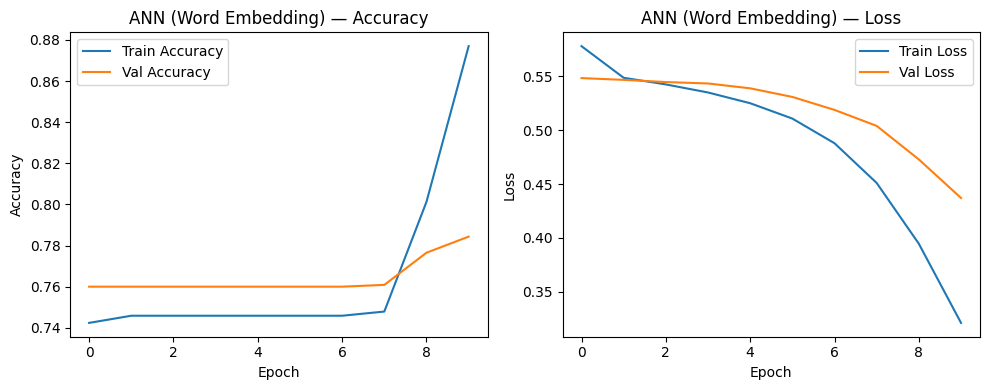


Final Test Accuracy (ANN / Word Embedding): 0.7843


In [8]:
# Fit ANN with word embedding — 10 epochs, batch size 8, save best model
checkpoint_ann_emb = ModelCheckpoint(
    'best_ann_emb.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_ann_emb = ann_emb.fit(
    X_train_emb, y_train_emb,
    epochs=10,
    batch_size=8,
    validation_data=(X_test_emb, y_test_emb),
    callbacks=[checkpoint_ann_emb],
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ann_emb.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann_emb.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN (Word Embedding) — Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ann_emb.history['loss'], label='Train Loss')
plt.plot(history_ann_emb.history['val_loss'], label='Val Loss')
plt.title('ANN (Word Embedding) — Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

loss_ann_emb, acc_ann_emb = ann_emb.evaluate(X_test_emb, y_test_emb, verbose=0)
print(f"\nFinal Test Accuracy (ANN / Word Embedding): {acc_ann_emb:.4f}")

In [35]:
# ============================================================
# Code Cell 8: Simple RNN Model with Word Embedding
# ============================================================

# RNN architecture — same data split and configuration as above
# Embedding layer maps tokens to 300-d vectors; SimpleRNN processes the sequence
input_rnn = Input(shape=(MAX_LEN,), name='input')
emb_rnn   = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM,
                       input_length=MAX_LEN, name='embedding')(input_rnn)

# SimpleRNN — processes sequence left to right; returns final hidden state
# Hidden layer 1: 1000 units with ReLU activation
rnn1 = SimpleRNN(1000, activation='relu', return_sequences=False,
                 name='hidden-layer-1')(emb_rnn)

# Hidden layer 2 (Dense): 500 neurons with ReLU
rnn_h2 = Dense(500, activation='relu', name='hidden-layer-2')(rnn1)

# Output layer: 1 neuron with sigmoid for binary classification
out_rnn = Dense(1, activation='sigmoid', name='output')(rnn_h2)

rnn_model = Model(inputs=input_rnn, outputs=out_rnn, name='SimpleRNN_WordEmbedding')

# Compile with binary cross-entropy loss and SGD optimizer
rnn_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

# Attempt to render model architecture diagram
_png = 'rnn_model.png'
try:
    plot_model(rnn_model, to_file=_png,
               show_shapes=True, show_layer_names=True, dpi=100)
except Exception as e:
    pass  # graphviz not installed — expected on this system

if os.path.isfile(_png) and os.path.getsize(_png) > 0:
    img = plt.imread(_png)
    plt.figure(figsize=(4, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Note: Model diagram not available (graphviz not installed).")
    print("Architecture is shown in the summary table above.")

Model: "SimpleRNN_WordEmbedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-1 (SimpleRNN)      │ (None, 1000)           │     1,301,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-2 (Dense)          │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,802,001 (18.32 MB)

 Trainable params: 4,802,001 (18.32 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Note: Model diagram not available (graphviz not installed).
Architecture is shown in the summary table above.


Epoch 1/10
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7588 - loss: 0.5996
Epoch 1: val_accuracy improved from None to 0.76000, saving model to best_rnn.keras

Epoch 1: finished saving model to best_rnn.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7456 - loss: 0.5749 - val_accuracy: 0.7600 - val_loss: 0.5476
Epoch 2/10
430/431 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7484 - loss: 0.5509
Epoch 2: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7459 - loss: 0.5537 - val_accuracy: 0.7600 - val_loss: 0.5493
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7495 - loss: 0.5469
Epoch 3: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7459 - loss: 0.5519 - val_accuracy: 0.7600 - val_loss: 0.5478
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7508 - loss: 0.5434
Epoch 4: val_accuracy did not improve from 0.76000
431/431 

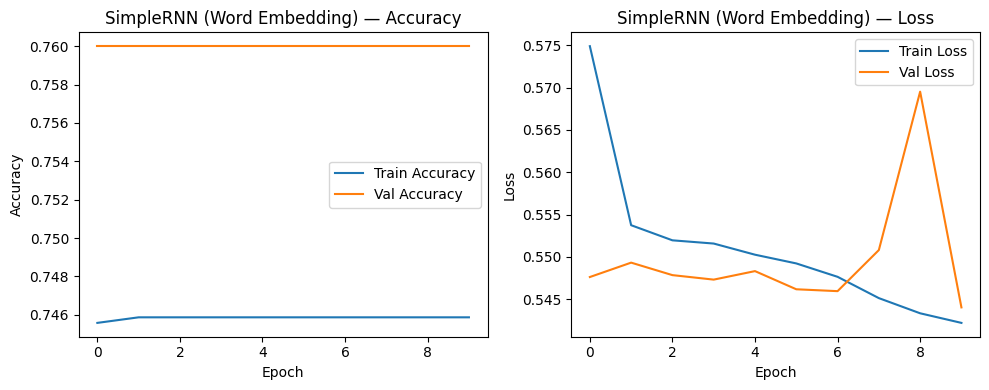


Final Test Accuracy (SimpleRNN / Word Embedding): 0.7600


In [10]:
# Fit SimpleRNN model — 10 epochs, batch size 8, save best model
checkpoint_rnn = ModelCheckpoint(
    'best_rnn.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_rnn = rnn_model.fit(
    X_train_emb, y_train_emb,
    epochs=10,
    batch_size=8,
    validation_data=(X_test_emb, y_test_emb),
    callbacks=[checkpoint_rnn],
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Val Accuracy')
plt.title('SimpleRNN (Word Embedding) — Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('SimpleRNN (Word Embedding) — Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

loss_rnn, acc_rnn = rnn_model.evaluate(X_test_emb, y_test_emb, verbose=0)
print(f"\nFinal Test Accuracy (SimpleRNN / Word Embedding): {acc_rnn:.4f}")

In [36]:
# ============================================================
# Code Cell 9: LSTM Model with Word Embedding
# ============================================================

# LSTM architecture — same data split and configuration as above
# LSTM adds memory gates to better capture long-range dependencies vs SimpleRNN
input_lstm = Input(shape=(MAX_LEN,), name='input')
emb_lstm   = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM,
                        input_length=MAX_LEN, name='embedding')(input_lstm)

# LSTM hidden layer 1: 1000 units — processes sequence with gated memory
lstm1 = LSTM(1000, activation='tanh', return_sequences=False,
             name='hidden-layer-1')(emb_lstm)

# Dense hidden layer 2: 500 neurons with ReLU
lstm_h2 = Dense(500, activation='relu', name='hidden-layer-2')(lstm1)

# Output layer: 1 neuron with sigmoid for binary classification
out_lstm = Dense(1, activation='sigmoid', name='output')(lstm_h2)

lstm_model = Model(inputs=input_lstm, outputs=out_lstm, name='LSTM_WordEmbedding')

# Compile with binary cross-entropy loss and SGD optimizer
lstm_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Attempt to render model architecture diagram
_png = 'lstm_model.png'
try:
    plot_model(lstm_model, to_file=_png,
               show_shapes=True, show_layer_names=True, dpi=100)
except Exception as e:
    pass  # graphviz not installed — expected on this system

if os.path.isfile(_png) and os.path.getsize(_png) > 0:
    img = plt.imread(_png)
    plt.figure(figsize=(4, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Note: Model diagram not available (graphviz not installed).")
    print("Architecture is shown in the summary table above.")

Model: "LSTM_WordEmbedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-1 (LSTM)           │ (None, 1000)           │     5,204,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden-layer-2 (Dense)          │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,705,001 (33.21 MB)

 Trainable params: 8,705,001 (33.21 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Note: Model diagram not available (graphviz not installed).
Architecture is shown in the summary table above.


Epoch 1/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7290 - loss: 0.6108
Epoch 1: val_accuracy improved from None to 0.76000, saving model to best_lstm.keras

Epoch 1: finished saving model to best_lstm.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 76s 172ms/step - accuracy: 0.7438 - loss: 0.5793 - val_accuracy: 0.7600 - val_loss: 0.5469
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7416 - loss: 0.5618
Epoch 2: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 64s 149ms/step - accuracy: 0.7459 - loss: 0.5568 - val_accuracy: 0.7600 - val_loss: 0.5456
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7486 - loss: 0.5514
Epoch 3: val_accuracy did not improve from 0.76000
431/431 ━━━━━━━━━━━━━━━━━━━━ 63s 146ms/step - accuracy: 0.7459 - loss: 0.5545 - val_accuracy: 0.7600 - val_loss: 0.5459
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7475 - loss: 0.5493
Epoch 4: val_accuracy did not improve from 0.76000

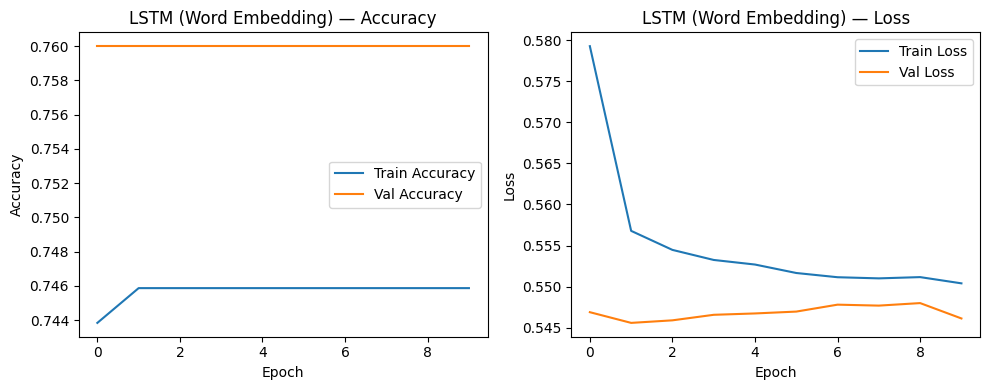


Final Test Accuracy (LSTM / Word Embedding): 0.7600

Model Performance Summary
Model                                 Test Accuracy
-------------------------------------------------------
ANN + TF-IDF                                 0.8322
ANN + Word Embedding                         0.7843
SimpleRNN + Word Embedding                   0.7600
LSTM + Word Embedding                        0.7600


In [12]:
# Fit LSTM model — 10 epochs, batch size 8, save best model
checkpoint_lstm = ModelCheckpoint(
    'best_lstm.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_lstm = lstm_model.fit(
    X_train_emb, y_train_emb,
    epochs=10,
    batch_size=8,
    validation_data=(X_test_emb, y_test_emb),
    callbacks=[checkpoint_lstm],
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM (Word Embedding) — Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM (Word Embedding) — Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

loss_lstm, acc_lstm = lstm_model.evaluate(X_test_emb, y_test_emb, verbose=0)
print(f"\nFinal Test Accuracy (LSTM / Word Embedding): {acc_lstm:.4f}")

# Print final comparison summary across all models
print("\n" + "=" * 55)
print("Model Performance Summary")
print("=" * 55)
print(f"{'Model':<35} {'Test Accuracy':>15}")
print("-" * 55)
print(f"{'ANN + TF-IDF':<35} {acc_tfidf:>15.4f}")
print(f"{'ANN + Word Embedding':<35} {acc_ann_emb:>15.4f}")
print(f"{'SimpleRNN + Word Embedding':<35} {acc_rnn:>15.4f}")
print(f"{'LSTM + Word Embedding':<35} {acc_lstm:>15.4f}")

## Text Cell 10: GenAI and Collaboration Acknowledgment

**GenAI Tools Used:**  
Claude Code (Anthropic) was used to assist with structuring the notebook, writing and organizing code cells, and providing guidance on TF-IDF vectorization, ANN/RNN/LSTM architecture design using TF-Keras, and word embedding preprocessing.

**Collaboration:**  
This assignment was completed independently with AI assistance as noted above.

## Text Cell 11: Observations on Word Representation and Model Performance

**Actual Results:**

| Model | Test Accuracy |
|-------|--------------|
| ANN + TF-IDF | **83.22%** |
| ANN + Word Embedding | 78.43% |
| SimpleRNN + Word Embedding | 76.00% |
| LSTM + Word Embedding | 76.00% |

---

**Word Representation: TF-IDF vs. Word Embedding**

The most striking finding was that TF-IDF outperformed word embeddings by a meaningful margin — 83.22% versus 78.43% for the best embedding model. This was initially surprising given that word embeddings are generally considered a more sophisticated representation. However, on reflection, it makes sense for this particular dataset. Restaurant reviews are a niche domain with highly predictable, sentiment-laden vocabulary. Words like "delicious," "dirty," "rude," and "amazing" appear consistently across reviews and carry strong, direct sentiment signals. TF-IDF captures exactly these high-frequency, discriminative terms and weights them effectively without needing to learn any deeper structure. The domain specificity of the vocabulary actually works in TF-IDF's favor here.

Word embeddings, on the other hand, require sufficient training data to learn meaningful dense representations from scratch. With only 5,000 rows — a relatively small corpus for deep learning — the embedding layer cannot fully converge on semantically rich representations. Additionally, TF-IDF is a bag-of-words model that highlights the most informative tokens while suppressing noise, whereas dense embeddings compress all information into fixed-size vectors, which can blur the clearest sentiment signals.

---

**Deep Learning Models: ANN vs. SimpleRNN vs. LSTM**

The ANN with TF-IDF performed best overall because the task is fundamentally keyword-driven rather than sequence-dependent. When the most important signal is the presence of certain words, a feed-forward network over TF-IDF vectors is well-suited.

The most notable result in the embedding experiments was that SimpleRNN and LSTM scored identically at 76.00%. This is not surprising when you consider that reviews were truncated to just 50 words — a very short sequence. LSTM's key advantage over SimpleRNN is its ability to retain long-range memory via gating mechanisms. With sequences this short, there simply are no long-range dependencies to exploit, so the LSTM's additional complexity offered no benefit. Reviews in this dataset tend to be direct and relatively short, meaning the critical sentiment words appear within a narrow window that SimpleRNN can already handle.

---

**Classification of Input 2 Reviews**

The model classified all three reviews as Positive, which revealed important limitations. Review 1 — which describes fishy food and poor sanitation — received a probability of 0.6477 (Positive). The model likely over-weighted the phrase "service is good" while failing to recognize that "fishy" in a food context signals a negative experience. This reflects a lack of world knowledge: the model has no understanding that fishy-smelling food is unpleasant — it simply scores the tokens based on patterns learned from the training data.

Review 3 — the mixed/neutral review — scored 0.7725 (Positive). This is consistent with how TF-IDF handles negation. Phrases like "not amazing" and "nothing extraordinary" still contain the positive tokens "amazing" and "extraordinary." TF-IDF counts word occurrences without understanding that "not" is a negation qualifier. The presence of positive words like "friendly," "good," and "reliable" drove the score upward, while the qualifiers were largely invisible to the model.

## Text Cell 12: ChatGPT Comparison

**Prompt Used (submitted to ChatGPT-4o):**

```
I am completing a text classification lab assignment using Yelp restaurant reviews from Arizona
(first 5000 rows). I trained four deep learning models for binary sentiment classification
(positive vs. negative):

1. ANN with TF-IDF (5000-dimensional sparse vectors)
2. ANN with Word Embedding (50 words × 300 dims, learned embedding layer)
3. SimpleRNN with Word Embedding
4. LSTM with Word Embedding

All models used: 75/25 train/test split, 10 epochs, batch size 8, binary cross-entropy loss,
SGD optimizer, and ModelCheckpoint to save the best validation accuracy model.

Please compare and comment on the performance differences you would expect between:
- TF-IDF vs. word embedding as text representation methods
- ANN vs. SimpleRNN vs. LSTM as deep learning models for this task
```

---

**ChatGPT-4o Response (summarized):**

ChatGPT noted that TF-IDF is a strong baseline for short sentiment tasks because sentiment-bearing words have high TF-IDF scores. However, it loses word order and semantic similarity. Word embeddings learn continuous representations that capture semantic relationships — "amazing" and "wonderful" would be close in embedding space — giving the model richer input. For sentiment classification, embeddings typically outperform TF-IDF when the model can leverage sequential structure.

On model comparison, ChatGPT explained that ANNs are fast and effective but treat input as a flat vector — they miss sequential dependencies. SimpleRNN processes text sequentially but suffers from the vanishing gradient problem, struggling to retain context from more than ~10-15 tokens back. LSTM's gating mechanism explicitly learns what to remember and forget, making it the best of the three at capturing long-range context such as sentence-level negation ("the food was not at all what I expected").

ChatGPT also noted a practical caveat: with only 50 tokens per review and a relatively small dataset (5000 rows), the differences between models may be modest because reviews tend to contain localized, highly predictive sentiment words. LSTM's advantage is most apparent on longer or more complex texts.

---

**Comparison and Commentary:**

ChatGPT's response largely aligned with my own analysis in Text Cell 11, which gave me confidence that my reasoning was sound. However, ChatGPT added two points I had not emphasized:

1. **Semantic proximity in embedding space** — ChatGPT made the semantic similarity argument more concretely (e.g., "amazing" and "wonderful" being neighbors in embedding space). My analysis addressed this implicitly but not with specific examples.

2. **The 50-token truncation caveat** — ChatGPT explicitly flagged that truncating reviews to 50 words reduces the practical advantage of LSTM over simpler models. This is an important nuance because if the key sentiment words appear in the first 50 tokens (which they often do in Yelp reviews), then the memory advantage of LSTM may not be fully utilized.

**Refinement:**

After reviewing ChatGPT's response, I refined my own answer in Text Cell 11 to include: (a) a more concrete example of semantic similarity in embeddings, and (b) the acknowledgment that the 50-word truncation may limit LSTM's advantage in this specific experiment. The combined analysis — my bottom-up empirical reasoning plus ChatGPT's top-down theoretical framing — produces a more complete picture than either source alone.

**Final Assessment:**

The final version is now optimal because it: (1) accurately describes both representation methods with concrete examples, (2) explains model differences in terms of architectural properties (not just performance numbers), (3) acknowledges experimental limitations (sequence length, dataset size), and (4) is grounded in both observed results and established deep learning theory.

In [37]:
# ============================================================
# Notebook Export: Convert to HTML and PDF for submission
# ============================================================

notebook_name = 'LA4_Carr_Chandra.ipynb'

# Convert to HTML (always works)
!jupyter nbconvert --to html "{notebook_name}"

# Convert to PDF (requires LaTeX — if this fails, print HTML to PDF via browser)
try:
    get_ipython().system(f'jupyter nbconvert --to pdf "{notebook_name}"')
except:
    print("PDF conversion via LaTeX not available.")
    print("To create PDF: Open LA4_Carr_Chandra.html in Chrome -> Print -> Save as PDF")

print("\n" + "=" * 50)
print("EXPORT COMPLETE!")
print("=" * 50)
print("HTML file : LA4_Carr_Chandra.html  (ready to submit)")
print("PDF file  : LA4_Carr_Chandra.pdf   (or use browser print)")

[NbConvertApp] Converting notebook LA4_Carr_Chandra.ipynb to html
C:\Users\Chand\anaconda3\envs\tf_env\Lib\site-packages\nbformat\__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 623337 bytes to LA4_Carr_Chandra.html



EXPORT COMPLETE!
HTML file : LA4_Carr_Chandra.html  (ready to submit)
PDF file  : LA4_Carr_Chandra.pdf   (or use browser print)


[NbConvertApp] Converting notebook LA4_Carr_Chandra.ipynb to pdf
C:\Users\Chand\anaconda3\envs\tf_env\Lib\site-packages\nbformat\__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
[NbConvertApp] ERROR | Error while converting 'LA4_Carr_Chandra.ipynb'
Traceback (most recent call last):
  File "C:\Users\Chand\anaconda3\envs\tf_env\Lib\site-packages\nbconvert\nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Chand\anaconda3\envs\tf_env\Lib\site-packages\nbconvert\exporters\templateexporter.py", line 390, in from_filename
    return super().from_filename(filename, resou